In [15]:
from langchain_openai import AzureOpenAIEmbeddings, AzureChatOpenAI
from langchain_chroma import Chroma
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
import os
from langchain_core.messages import HumanMessage, SystemMessage

In [4]:
persist_directory = './chroma_storage'
image_directory = './images'

In [5]:
embeddings = AzureOpenAIEmbeddings(
    azure_deployment="AA-text-embedding-3-large",
    openai_api_version="2024-02-01",
)

llm = AzureChatOpenAI(
    azure_deployment="AA-gpt4-o",
    openai_api_version="2024-02-01",
)

In [6]:
db = Chroma(persist_directory="./chroma_storage", embedding_function=embeddings)  # Load from storage

In [ ]:
import re

def get_all_images(similar_docs):
    all_images = {}
    for doc in similar_docs:
        page_content = doc.page_content
        # search for the patten: ![](images/file_name.jpg)
        
        # find all the images
        images = get_images_from_text(page_content)
        
        for image in images:
            
            ref = image[0]
            file_name = image[1]
            
            if file_name not in all_images:
                all_images[file_name] = ref
            elif ref.strip() != '' and all_images[file_name] != ref:
                all_images[file_name] = ref
    return all_images
# remove the 

def get_images_from_text(text):
    images = re.findall(r"!\[(.*)\]\((images/.[^\)]+)\)", text)
    return images

    

In [9]:
retriever = db.as_retriever()

In [10]:
from langchain.chat_models import AzureChatOpenAI
from langchain.embeddings import AzureOpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.schema import SystemMessage, HumanMessage
from langchain.prompts import ChatPromptTemplate
import base64


In [11]:
from PIL import Image
import base64
import io

def encode_image(image_path):
    with Image.open(image_path) as img:

        # Get the original dimensions
        width, height = img.size
        
        # Calculate the new dimensions, maintaining aspect ratio
        if width > height:
            new_width = 384
            new_height = int(height * (384 / width))
        else:
            new_height = 384
            new_width = int(width * (384 / height))
        
        # Resize the image
        img_resized = img.resize((new_width, new_height), Image.LANCZOS)
        # Convert to RGB if it's not already (e.g., for PNG with transparency)
        if img_resized.mode != 'RGB':
            img_resized = img_resized.convert('RGB')
        
        # Save the resized image to a bytes buffer
        buffer = io.BytesIO()
        img_resized.save(buffer, format="JPEG")
        
        # Encode the image
        return base64.b64encode(buffer.getvalue()).decode('utf-8')


In [12]:
def create_text_message(context):
    return HumanMessage(content=context)

def create_image_messages(image_paths, image_descriptions):
    image_messages = []
    for i, image_path in enumerate(image_paths):

        img_base64 = encode_image(image_path)
        image_description = image_descriptions[i]
        image_message = HumanMessage(
            content=[
                {"type": "text", "text": image_description},
                {"type": "text", "text": image_path},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                },
            ]
        )
        image_messages.append(image_message)
    return image_messages



In [61]:
system_template = """You are an AI assistant specializing in materials science and engineering.
Your task is to answer questions based on the provided context, which includes both text and images.
You should refer to images or tables as frequently as possible with the format of the markdown like ![image_description](images/image_or_table_file_name) in your answer."""

human_template = """Question: {question}
Please answer the question based on the provided context, including both text and image information when applicable."""


In [62]:
question1 = "What is the stress-strain curve for ductile steel?"
question2 = "Show me the colour, tensile strength, melting point of some non-ferrous metal."
question = question1
similar_docs = db.similarity_search(question, k=4)
all_images = get_all_images(similar_docs)

# Build context
text_context = "\n\n".join([doc.page_content for doc in similar_docs])

# Create HumanMessages
text_message = create_text_message(text_context)
image_descriptions = list(all_images.values())
image_paths = list(all_images.keys())
image_messages = create_image_messages(image_paths, image_descriptions)


[HumanMessage(content=[{'type': 'text', 'text': 'Stress-strain curve for ductile material'}, {'type': 'text', 'text': 'images/27ed679087f4715d3590e3d062d83e3049561e07110c05316a11ddccb15c6715.jpg'}, {'type': 'image_url', 'image_url': {'url': ''}}], additional_kwargs={}, response_metadata={}),
 HumanMessage(content=[{'type': 'text', 'text': 'Dimensions of a standard tensile test-piece'}, {'type': 'text', 'text': 'images/ef0205e9d317792b34dba25d85f6a434884590b3d5a6eac8ee68f28d8c94ee6c.jpg'}, {'type': 'image_url', 'image_url': {'url': ''}}], additional_kwargs={}, response_metadata={}),
 HumanMessage(content=[{'type': 'text', 'text': 'Stress-strain curve for brittle material'}, {'type': 'text', 'text': 'images/29d764321a051b3ba1dc8b4f0a7071b1f23abb6fbf677defa9c25ef14aa6a902.jpg'}, {'type': 'image_url', 'image_url': {'url': ''}}], additional_kwargs={}, response_metadata={}),
 HumanMessage(content=[{'type': 'text', 'text': 'IZOD test specimen'}, {'type': 'text', 'text': 'images/ebafa765501d97
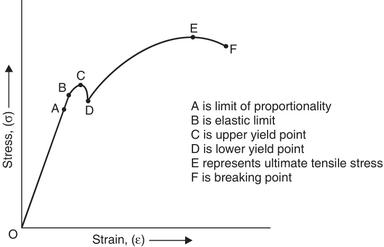
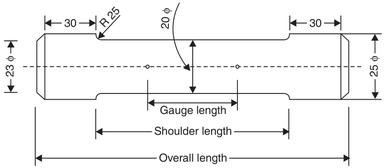
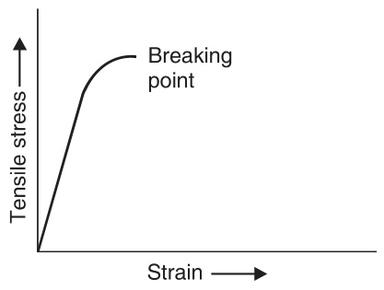
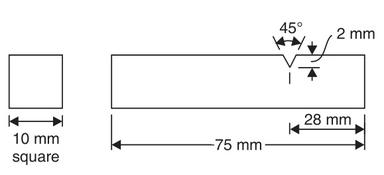
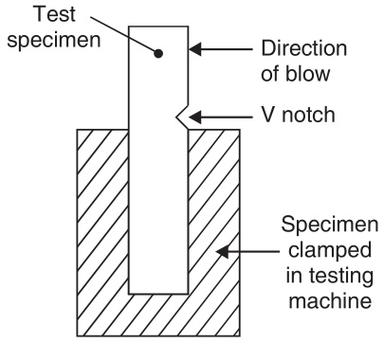

In [63]:
image_messages

In [64]:
# Create messages
system_message = SystemMessage(content=system_template)
question_message = HumanMessage(content=human_template.format(question=question))


In [65]:
# Aggregate all messages
all_messages = [system_message, question_message, text_message] + image_messages


In [66]:
similar_docs

[Document(metadata={'source': 'data/unit1/manufacturing-unit1.md'}, page_content='\n# STRESS-STRAIN DIAGRAM  \n\nConsider a rod of initial length $L_{0}$ and area $A_{0}$ which is subjected to a load $F_{\\mathrm{.}}$ The stress $\\upsigma$ is the force per unit area, and strain ε is the change in length (8) divided by the initial length. Thus,  \n\n$$\n\\begin{array}{r}{\\mathrm{Stress}\\ \\sigma=F/A_{0}}\\\\ {\\mathrm{Strain}\\ \\varepsilon=\\delta/L_{0}}\\end{array}\n$$  \n\nThe O-e curve for a material (say mild steel) is shown in the ![Stress-strain curve for ductile material](images/27ed679087f4715d3590e3d062d83e3049561e07110c05316a11ddccb15c6715.jpg). Up to the proportionality point $A$ , the stress-strain variation is linear. Up to this point Hooke\'s law holds good.  \n\ni.e., $\\begin{array}{l}{\\mathtt{C}\\propto\\mathtt{E}}\\\\ {\\upsigma=E\\mathrm{\\mathrm{g}}}\\end{array}$ or  \n\nwhere $E$ is the Young\'s modulus commonly called modulus of elasticity.  \n\nBeyond point $

[SystemMessage(content='You are an AI assistant specializing in materials science and engineering.\nYour task is to answer questions based on the provided context, which includes both text and images.\nYou should refer to images or tables as frequently as possible with the format of the markdown like ![image_description](images/image_or_table_file_name) in your answer.', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='Question: What is the stress-strain curve for ductile steel?\nPlease answer the question based on the provided context, including both text and image information when applicable.', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='\n# STRESS-STRAIN DIAGRAM  \n\nConsider a rod of initial length $L_{0}$ and area $A_{0}$ which is subjected to a load $F_{\\mathrm{.}}$ The stress $\\upsigma$ is the force per unit area, and strain ε is the change in length (8) divided by the initial length. Thus,  \n\n$$\n\\begin{array}{r}{\\mathrm{Stress}\
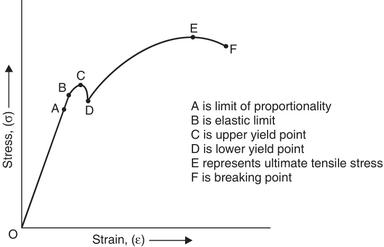
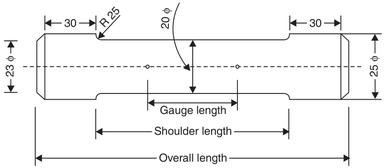
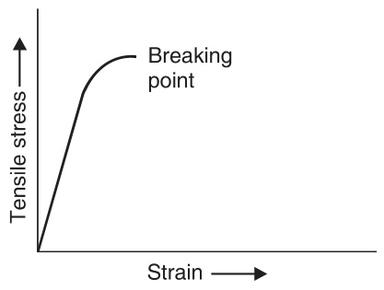
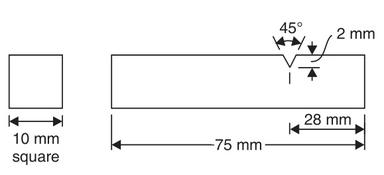
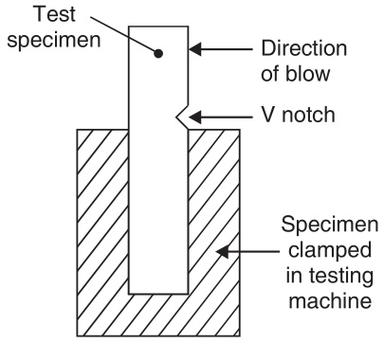

In [67]:
all_messages

In [68]:
print(text_context)


# STRESS-STRAIN DIAGRAM  

Consider a rod of initial length $L_{0}$ and area $A_{0}$ which is subjected to a load $F_{\mathrm{.}}$ The stress $\upsigma$ is the force per unit area, and strain ε is the change in length (8) divided by the initial length. Thus,  

$$
\begin{array}{r}{\mathrm{Stress}\ \sigma=F/A_{0}}\\ {\mathrm{Strain}\ \varepsilon=\delta/L_{0}}\end{array}
$$  

The O-e curve for a material (say mild steel) is shown in the ![Stress-strain curve for ductile material](images/27ed679087f4715d3590e3d062d83e3049561e07110c05316a11ddccb15c6715.jpg). Up to the proportionality point $A$ , the stress-strain variation is linear. Up to this point Hooke's law holds good.  

i.e., $\begin{array}{l}{\mathtt{C}\propto\mathtt{E}}\\ {\upsigma=E\mathrm{\mathrm{g}}}\end{array}$ or  

where $E$ is the Young's modulus commonly called modulus of elasticity.  

Beyond point $A$ and up to point $B$ , material remains elastic i.e., the material returns to its original condition of the forces actin

images/27ed679087f4715d3590e3d062d83e3049561e07110c05316a11ddccb15c6715.jpg


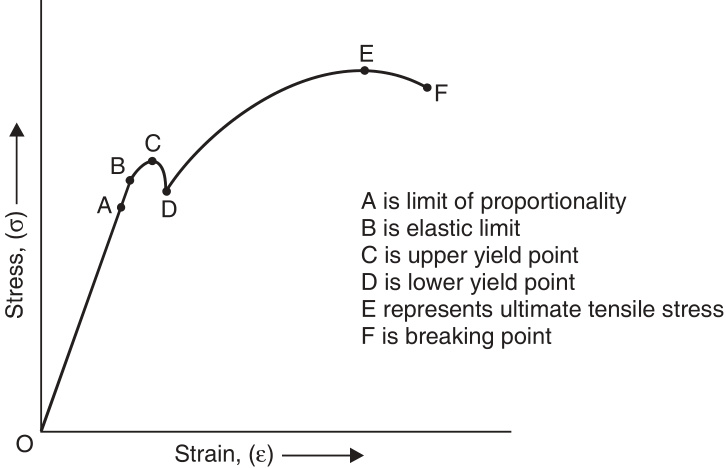

images/ef0205e9d317792b34dba25d85f6a434884590b3d5a6eac8ee68f28d8c94ee6c.jpg


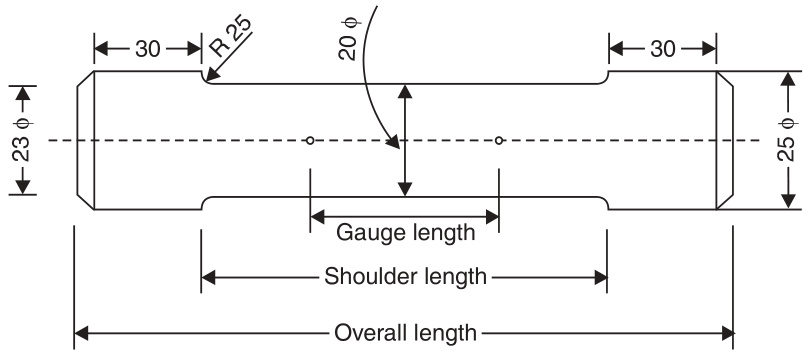

images/29d764321a051b3ba1dc8b4f0a7071b1f23abb6fbf677defa9c25ef14aa6a902.jpg


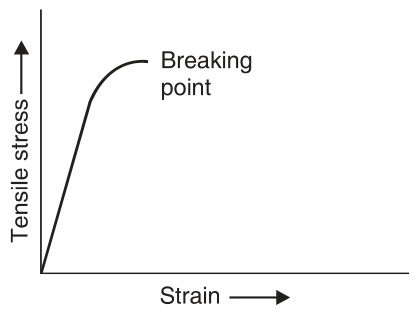

images/ebafa765501d973566b4e175140198d0854fb7722d2c10fecb32f1779d45d085.jpg


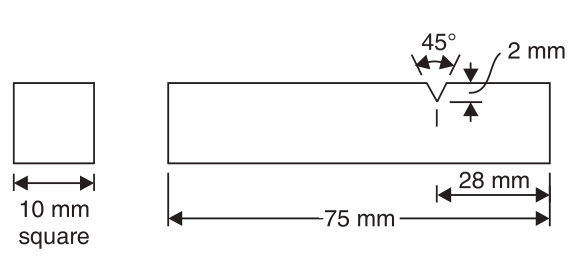

images/afc44a1e62cb5eee8eec44366cf8c3b5e789418d5c05d1c4a142ac2ab0335765.jpg


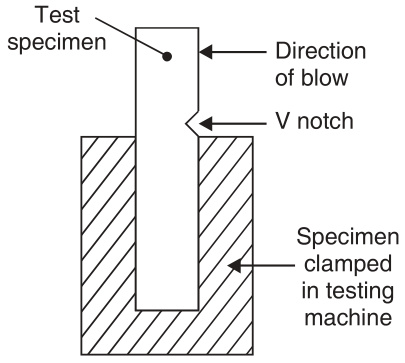

In [69]:
for img_file in list(all_images.keys()):
    print(img_file)
    # show the image
    display(Image.open(img_file))


In [70]:
# Get the response from the LLM
response = llm(all_messages)

In [71]:
print(response.content)

The stress-strain curve for ductile steel, as shown in the image, consists of several key points and regions:

1. **Proportional Limit (A):** The stress and strain are directly proportional, following Hooke's Law. The curve is linear up to this point.

2. **Elastic Limit (B):** Beyond this point, permanent deformation begins. The material will not return to its original shape if the stress is removed.

3. **Yield Points (C and D):** The upper (C) and lower (D) yield points indicate the onset of plastic deformation. Stress can decrease slightly with increasing strain.

4. **Strain Hardening:** After the yield point, the material undergoes strain hardening, where the stress increases with strain until it reaches the ultimate tensile strength.

5. **Ultimate Tensile Strength (E):** The maximum stress the material can withstand.

6. **Necking and Breaking Point (F):** After reaching the ultimate tensile strength, necking occurs, and the cross-sectional area decreases until the material fin

In [11]:
from langchain.prompts import ChatPromptTemplate

system_template = """You are an AI assistant specializing in materials science and engineering. 
Your task is to answer questions based on the provided context, which includes both text and images. 
When referring to images, use the format 'Image X' where X is the image number.

Context:
{context}

Please provide detailed and accurate answers, incorporating information from both the text and images when relevant."""

human_template = """Question: {question}

Please answer the question based on the provided context, including both text and image information when applicable."""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", system_template),
    ("human", human_template),
])

In [37]:
from langchain_core.prompts import ChatPromptTemplate

# Prompt
prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
These summaries will be embedded and used to retrieve the raw text or table elements. \
Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {context} """
prompt = ChatPromptTemplate.from_template(prompt_text)

In [38]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [39]:
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [42]:
from langchain.globals import set_debug

set_debug(True)

In [43]:
rag_chain.invoke("What is the stress-strain curve for ductile steel?", debug=True)

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "input": "What is the stress-strain curve for ductile steel?"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<context,question>] Entering Chain run with input:
{
  "input": "What is the stress-strain curve for ductile steel?"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<context,question> > chain:RunnableSequence] Entering Chain run with input:
{
  "input": "What is the stress-strain curve for ductile steel?"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<context,question> > chain:RunnablePassthrough] Entering Chain run with input:
{
  "input": "What is the stress-strain curve for ductile steel?"
}
[chain/end] [chain:RunnableSequence > chain:RunnableParallel<context,question> > chain:RunnablePassthrough] s] Exiting Chain run with output:
{
  "output": "What is the stress-strain curve for ductile steel?"
}
[chain/start] [chain:RunnableSequence > chain:RunnableP

"The text provides an in-depth explanation of stress-strain diagrams, focusing on both ductile and brittle materials. Key concepts include stress as force per unit area and strain as change in length over initial length. The stress-strain curve for ductile materials like mild steel is initially linear (obeying Hooke's Law) up to point A, beyond which it remains elastic until point B. Beyond B, plastic deformation and yield points C and D occur, with ultimate tensile strength (UTS) at point E. The text discusses plastic deformation effects, such as strain hardening, and the decrease in cross-sectional area leading to neck formation and eventual specimen breakage. For brittle materials, the curve lacks a yield point and breaks suddenly. The text also covers related properties such as malleability, ductility, brittleness, stiffness, resilience, fatigue failure, and creep failure. The document concludes with questions about stress-strain curves, material properties, and different types of 